<a href="https://colab.research.google.com/github/IamShubhamGupto/WSSL-Weighted-Self-Supervised-Learning-for-Image-Inpainting/blob/main/notebooks/inference/WSSL_inference_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code

In [ ]:
!pip install gdown

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow import keras
from keras.utils.data_utils import get_file
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
kernel = (3,3)
pool = (2,2)
upstride = (2,2)
activation = 'relu'
class inpaintingModel:
  def build_encoder(self, inputs):
    conv1, pool1 = self.__ConvBlock(64, kernel, pool, activation, 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(128, kernel, pool, activation, 'same', pool1)
    conv3, pool3 = self.__ConvBlock(256, kernel, pool, activation, 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(512, kernel, pool, activation, 'same', pool3) 
    conv5, pool5 = self.__ConvBlock(1024, kernel, pool, activation, 'same', pool4)

    return conv1, conv2, conv3, conv4, conv5, pool5

  def build_decoder(self, conv1, conv2, conv3, conv4, conv5, pool_layer):
    conv6, up7 = self.__UpConvBlock(2048, 1024, kernel, pool, upstride, activation, 'same', pool_layer, conv5)
    conv7, up8 = self.__UpConvBlock(1024, 512, kernel, pool, upstride, activation, 'same', up7, conv4)
    conv8, up9 = self.__UpConvBlock(512, 256, kernel, pool, upstride, activation, 'same', up8, conv3)
    conv9, up10 = self.__UpConvBlock(256, 128, kernel, pool, upstride, activation, 'same', up9, conv2)
    conv10, up11 = self.__UpConvBlock(128, 64, kernel, pool, upstride, activation, 'same', up10, conv1)

    conv11 = self.__ConvBlock(32, kernel, pool, activation, 'same', up11, False)
    
    outputs = keras.layers.Conv2D(3, kernel, activation='sigmoid', padding='same')(conv11)

    return outputs
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(224,224,3)):
    inputs = keras.layers.Input(input_size)
    conv1, conv2, conv3, conv4, conv5, pool_layer = self.build_encoder(inputs)
    outputs = self.build_decoder(conv1, conv2, conv3, conv4, conv5, pool_layer)
    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [ ]:
!gdown https://drive.google.com/uc?id=1CP4vJekB3ryEupq_E7qf41dswengMYhb

Downloading...
From: https://drive.google.com/uc?id=1CP4vJekB3ryEupq_E7qf41dswengMYhb
To: /content/sha-sat-70_30_downstream.h5
100% 1.34G/1.34G [00:06<00:00, 199MB/s]


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
def custom_loss(y_true, y_pred):
    alpha = 0.84
    loss_ssim = SSIMLoss(y_true, y_pred)
    logcosh = tf.keras.losses.logcosh(y_true, y_pred)
    return (1-alpha)*loss_ssim + alpha*logcosh

In [ ]:
def get_random_crop(image, crop_height, crop_width):

    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]
    return crop

In [ ]:
def createMask(img, thick = 3, lines = 10):
    l,b,h = img.shape
    mask = np.full((l,b,h), 255, np.uint8)
    for _ in range(np.random.randint(1, lines)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, l), np.random.randint(1, l)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, b), np.random.randint(1, b)
      # Get random thickness of the line drawn
      # thickness = np.random.randint(1, thick)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,2,1),thick)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [ ]:
d_model = inpaintingModel().prepare_model()
d_model = load_model('/content/sha-sat-70_30_downstream.h5', custom_objects={'custom_loss': custom_loss,
                                                                             'dice_coef': dice_coef})

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!wget https://cachedimages.podchaser.com/256x256/aHR0cHM6Ly9jcmVhdG9yLWltYWdlcy5wb2RjaGFzZXIuY29tL2FlZGFlOTAwOTEwNmU3YzQ5ZGMyODdiYTZiNzYwMzUxLmpwZWc%3D/aHR0cHM6Ly93d3cucG9kY2hhc2VyLmNvbS9pbWFnZXMvbWlzc2luZy1pbWFnZS5wbmc%3D

--2022-01-09 17:25:07--  https://cachedimages.podchaser.com/256x256/aHR0cHM6Ly9jcmVhdG9yLWltYWdlcy5wb2RjaGFzZXIuY29tL2FlZGFlOTAwOTEwNmU3YzQ5ZGMyODdiYTZiNzYwMzUxLmpwZWc%3D/aHR0cHM6Ly93d3cucG9kY2hhc2VyLmNvbS9pbWFnZXMvbWlzc2luZy1pbWFnZS5wbmc%3D
Resolving cachedimages.podchaser.com (cachedimages.podchaser.com)... 172.66.40.139, 172.66.43.117, 2606:4700:3108::ac42:2b75, ...
Connecting to cachedimages.podchaser.com (cachedimages.podchaser.com)|172.66.40.139|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-01-09 17:25:07 ERROR 403: Forbidden.



# Inpainting demo

In [ ]:
image = cv2.imread('/content/00041.jpg')
maske = cv2.imread('/content/00042_train.png')

In [ ]:
image = get_random_crop(image, 224, 224)

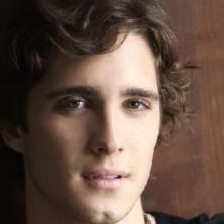

In [ ]:
cv2_imshow(image)

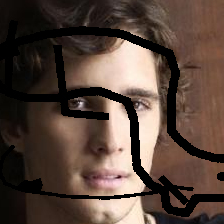

In [ ]:
mask = cv2.bitwise_and(image, maske)
cv2_imshow(mask)

In [ ]:
inpainted_image = d_model.predict(mask.reshape((1,)+mask.shape)/255.0)
inpainted_image = inpainted_image.reshape(inpainted_image.shape[1:])

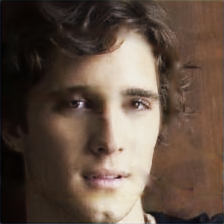

In [ ]:
cv2_imshow(inpainted_image*255.0)